# Play with pipeline

### Import

In [6]:
import os
PROJECT_PATH=os.getenv("IBENS_PROJECT_PATH") #Si bug: source ~/.bashrc
os.chdir(PROJECT_PATH)

import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

#DataModule
from disdiff_adaptaters.data_module import Shapes3DDataModule ,BloodMNISTDataModule
#Module
from disdiff_adaptaters.arch.vae import *
#utils
from disdiff_adaptaters.utils import *
#loss
from disdiff_adaptaters.loss import *
#ext
from chada.backbones.vit.chada_vit import ChAdaViT

from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from lightning import Trainer

BATCH_SIZE = 8

/home/alexandre/disdiff_adaptaters/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alexandre/disdiff_adaptaters/.venv/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/alexandre/disdiff_adaptaters/.venv/lib/python3.10/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/alexandre/disdiff_adaptaters/.venv/lib/python3.10/site-packages/timm/optim/optim_factory.py:7: FutureWarning: Importing fro

In [7]:
device = set_device()

device is at cpu


## Load data (choose a set)

**Choose the appropriate set :**

### 3DShapes

In [3]:
if device == "cuda" :
    shapes = Shapes3DDataModule(batch_size=BATCH_SIZE)
    shapes.prepare_data()
    shapes.setup(stage='fit')
    shapes_loader = shapes.train_dataloader()
else :
    images, labels = load_h5(Shapes3D.Path.H5)
    images = images[:32]
    labels = labels[:32]
    shapes_loader = DataLoader(TensorDataset(torch.tensor(images).permute(0,3,1,2), torch.tensor(labels)), batch_size=8, shuffle=True)

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
for batch in shapes_loader :
    images, labels = batch
    print(images.shape)
    break

torch.Size([8, 3, 64, 64])


### BloodMNIST

In [8]:
blood = BloodMNISTDataModule(batch_size=BATCH_SIZE)
blood.prepare_data()
blood.setup("fit")

torch.Size([3, 28, 28]) torch.Size([8, 1])


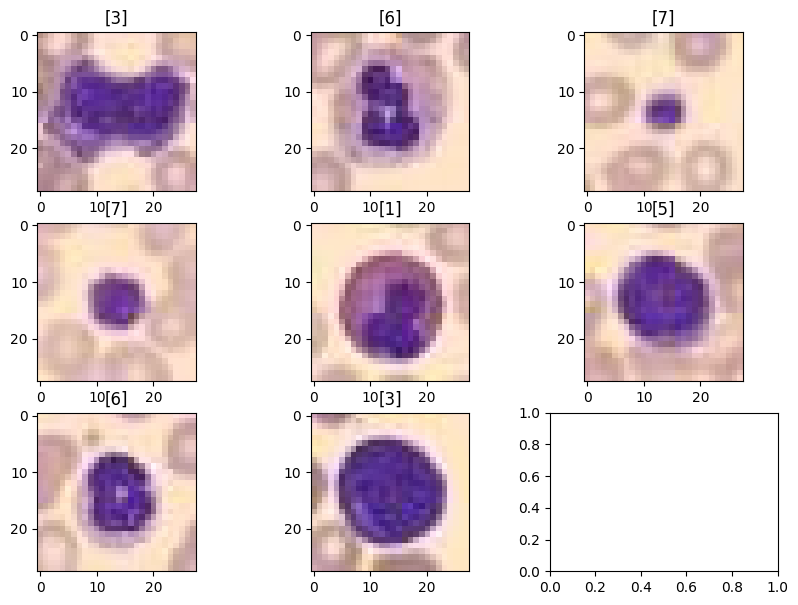

In [9]:
blood_loader = blood.train_dataloader()
for batch in blood_loader : 
    images, labels = batch
    print(images[0].shape, labels.shape)
    display(batch)
    break

### **Enter the correct loader** :

In [11]:
#Choose the right loader
loader = blood_loader
stop_at = 0 #If you want to test with only 'stop_at'+1 batches. To select all set enter : None

for batch in loader :
    img_size = batch[0].shape[2]
    in_channels = batch[0].shape[1]
    print(f"You have selected data with :\nimg_size={img_size}, with {in_channels} channels")
    break

You have selected data with :
img_size=28, with 3 channels


## Encoder (choose an encoder)

**Run the chosen encoder.**

### ChAda

In [14]:
# Params
PATCH_SIZE = 16
EMBED_DIM = 192
RETURN_ALL_TOKENS = False
MAX_NUMBER_CHANNELS = 10

In [15]:
model = ChAdaViT(
    patch_size=PATCH_SIZE,
    embed_dim=EMBED_DIM,
    return_all_tokens=RETURN_ALL_TOKENS,
    max_number_channels=MAX_NUMBER_CHANNELS,
)

In [16]:
state = torch.load(ChAda.Path.WEIGHTS, map_location="cpu", weights_only=False)["state_dict"]
for k in list(state.keys()):
    if "encoder" in k:
        state[k.replace("encoder", "backbone")] = state[k]
    if "backbone" in k:
        state[k.replace("backbone.", "")] = state[k]
    del state[k]
model.load_state_dict(state, strict=False)
model.to("cpu")
model.eval()
model.mixed_channels = True

FileNotFoundError: [Errno 2] No such file or directory: '/home/alexandre/disdiff_adaptaters/disdiff_adaptaters/arch/chada/weights.ckpt'

In [ ]:
print(images.shape, labels.shape)

(480000, 64, 64, 3) (480000, 6)


In [ ]:
data = []
for batch in train_loader :
    images, labels = batch
    data_batch = []
    for image, label in zip(images, labels) :
        data_batch.append(images[i],)

    break

<class 'torch.Tensor'>


In [ ]:
for batch in train_loader : 
    #unpack batch
    images, labels = batch

    #Format batch in order to collate
    data = []
    for image, label in zip(images, labels) :
        data.append((image, label))
    #Collate images
    channels_list, labels_list, num_channels_list = collate_images(data)

    #Forward
    feats = model(channels_list, index=0, list_num_channel=num_channels_list)
    break

In [ ]:
output

tensor([[ 1.3813, -0.8161,  1.0642, -1.8680,  1.3986,  1.1567,  0.6350, -0.0222,
          1.5576,  1.9850,  1.5999,  0.4893,  0.5862,  2.1450, -0.9456, -0.6991,
         -1.2963, -1.2560, -2.1907, -1.9560,  0.1671,  1.2622, -1.2758, -0.8391,
         -0.1157, -1.4872,  1.7005,  0.4986,  0.8209, -1.6139, -1.3855,  0.4419,
         -0.5098, -0.3220,  1.1783,  1.1320, -0.4826, -0.9351, -0.7490, -0.3625,
          0.9052, -0.0501,  0.2452, -0.2175,  0.1449,  0.4216,  0.0167,  0.5555,
          1.0213,  0.9465,  0.8716,  2.6457, -0.9982, -0.3541,  0.2795, -0.2061,
          0.2320, -0.7463, -0.5710, -0.3109,  1.9990,  2.0090,  0.1810,  1.7208,
         -0.3301, -1.1345,  0.5531, -0.2745, -0.2627, -1.6694, -1.1357, -0.2337,
          0.1739,  1.8382,  0.1912, -1.3422,  1.4479, -0.5516, -0.2163, -1.6908,
         -0.4320,  0.0068, -0.3481, -1.8300, -2.1380,  0.4883,  0.9845,  0.4305,
          1.6311, -0.5753,  1.4146, -0.2970,  0.0283,  0.8475, -0.3458,  0.7038,
          0.7426, -1.4992,  

### Variational Encoder

Let's display the PCA-latent space with VAE encoder

In [3]:
latent_dim = 64
encoder = Encoder(in_channels, img_size, latent_dim)

encoder.eval()
mus = []
logvars = []
labels = []

for i,batch in enumerate(loader) :
    image, label = batch

    mu, logvar = encoder(image)

    mus.append(mu)
    logvars.append(logvar)
    labels.append(label)
    if (stop_at is not None) and (stop_at == i) : break

try :
    mus = torch.cat(mus)
    logvars = torch.cat(logvars)
    labels = torch.cat(labels)
except TypeError as e : print("!!You have already run this cell.!!")
print(f"labels shape = {labels.shape}")

NameError: name 'Encoder' is not defined

Make sure that labels shape is at [Batch size, 1]. Preprocess here if needed :

In [ ]:
#labels[:, 0].unsqueeze(1).shape

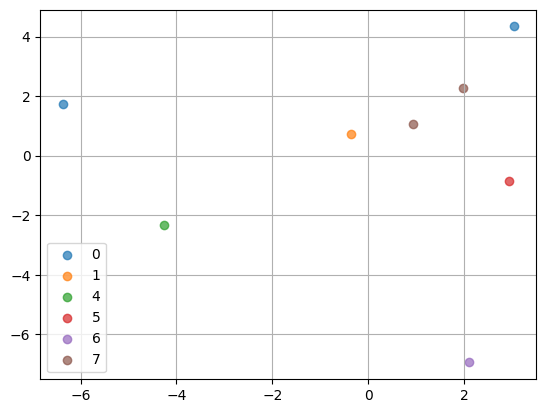

In [ ]:
assert labels.shape == (labels.shape[0], 1), "You have to preprocess labels before using pca_latent display function"
pca_latent((mus, logvars), labels)

## Decoder

In [12]:
#Sample latent
z = sample_from((mus, logvars))
print(f"Latent space is a {z.shape}")
decoder = Decoder(latent_dim, (3,28,28), encoder.out_encoder_shape)
x_hat_logits = decoder(z)
try: assert x_hat_logits.shape == (x_hat_logits.shape[0], in_channels, img_size, img_size)
except AssertionError as e : 
    print(x_hat_logits.shape)
    print("!!!!WARNING : reconstruction error : output of the decoder must be with the a same shape as the input")

NameError: name 'mus' is not defined

tensor(0.4797, grad_fn=<MinBackward1>) tensor(0.5248, grad_fn=<MaxBackward1>)


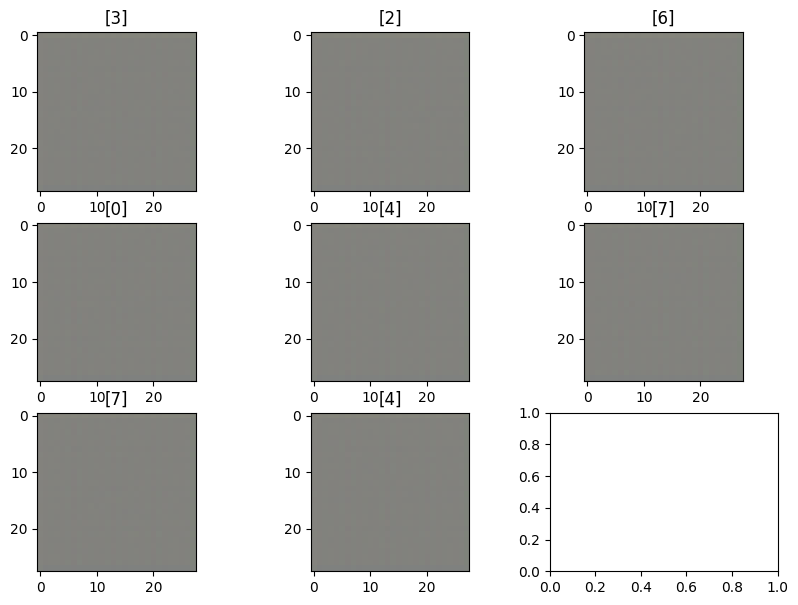

In [ ]:
assert x_hat_logits.shape==image.shape, "shape error"
print(x_hat_logits.min(), x_hat_logits.max())
display((x_hat_logits, labels))
loss_mse = mse(x_hat_logits, image)
loss_kl = kl(mus, logvars)

In [ ]:
loss_mse+loss_kl

tensor(1902.7190, grad_fn=<AddBackward0>)

## VAE - train

In [13]:
beta=1.0
vae = VAE(in_channels=in_channels, img_size=img_size, latent_dim=latent_dim, beta=beta)

In [14]:
max_epoch=5
version=f"vae_epoch={max_epoch}_beta={beta}_latent={latent_dim}"
trainer = Trainer(
        accelerator="auto",
        devices="auto",
        max_epochs=5,
        logger=TensorBoardLogger(
            save_dir=LOG_DIR,
            name=BloodMNIST.Path.VAE,
            version=version,
            default_hp_metric=False,
        ),
        callbacks=[
            ModelCheckpoint(monitor="loss/val", mode="min"),
            LearningRateMonitor("epoch"),
        ]
    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer(vae, blood)

/home/alexandre/disdiff_adaptaters/.venv/lib/python3.10/site-packages/lightning/pytorch/core/module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
